# Logistic Regression

Trong bài tập này, bạn sẽ thực hiện xây dựng một mô hình phân loại sử dụng Logistic Regression để nhận dạng một bức ảnh có phải là mèo hay không.

**Lưu ý**:
- Hạn chế sử dụng vòng lặp (`for`/`while`) trong code nếu không thực sự cần thiết.
- Sử dụng thư viện `numpy` để tính toán

## 1 - Thư viện ##

- `numpy`: thư viện tính toán
- `h5py`: thư viện tương tác với cơ sở dữ liệu dưới dạng h5 
- `matplotlib`: thư viện vẽ đồ thị


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lr_utils import load_dataset

%matplotlib inline

## 2 - Tổng quan bài toán ##

**Bài toán**: Bạn được cung cấp một cơ sở dữ liệu (h5 file) có chứa:
- Tập train gồm `m_train` bức ảnh, được gán nhãn là mèo (y=1) hoặc không phải mèo (y=0)
- Tập test gồm `m_test` bức ảnh, gán nhãn tương tự.
- Mỗi bức ảnh có chiều `(num_px, num_px, 3)` trong đó `num_px` là số lượng pixel theo mỗi chiều, `3` là 3 kênh (RGB).

Bạn sẽ thực hiện xây dựng một thuật toán nhận dạng ảnh để phân loại các bức ảnh là mèo hay không.


### 2.1. Loading the data (cat/non-cat) ###
**Lưu ý**: Hàm `load_dataset()` được cung cấp sẵn, trả về 5 giá trị `train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes`:
- `train_set_x_orig`: đầu vào của tập train
- `train_set_y`: đầu ra (nhãn) của trập train
- `test_set_x_orig`: đầu vào của tập test
- `test_set_y`: đầu ra (nhãn) của trập test
- `classes`: phân loại (cat/non-cat) sử dụng để in ra dự đoán "cat" hoặc "non-cat" thay vì "1" hoặc "0" 

Cuối mỗi biến có hậu tố "_orig" thể hiện đây là biến gốc ban đầu, biến này sẽ được xử lý ở các phần sau.


In [2]:
# Loading dataset
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

### 2.2. Visualize an example ###
**Lưu ý**: thay đổi giá trị `index` để xem ví dụ khác.

y = 0, it's a 'non-cat' picture.


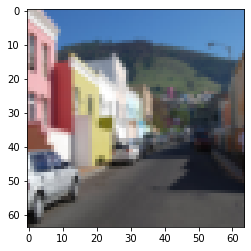

In [3]:
index = 1 
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[0, index]) + ", it's a '" + classes[train_set_y[0, index]].decode("utf-8") +  "' picture.")


### 2.3. Exercise ###

**Bài tập**: tính toán các giá trị sau:
- `m_train`: số lượng mẫu của tập train
- `m_test`: số lượng mẫu của tập test
- `num_px`: số lượng pixel theo mỗi chiều (= height = width của 1 bức ảnh) 

**Gợi ý**: `train_set_x_orig` là một numpy-array có chiều là `(m_train, num_px, num_px, 3)`. Ví dụ, có thể lấy giá trị `m_train` bằng lệnh `train_set_x_orig.shape[0]`.


In [4]:
### START CODE HERE ###
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Expected Output for m_train, m_test and num_px**: 
- Number of training examples: m_train = 209
- Number of testing examples: m_test = 50
- Height/Width of each image: num_px = 64

## 3 - Kiến trúc Logistic Regression

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Các công thức sử dụng trong thuật toán**:

Với mỗi ví dụ $x^{(i)}$:
- Tính giá trị $z$:
$$z^{(i)} = w^T x^{(i)} + b$$
- Tính giá trị dự đoán $\hat{y}$ với hàm kích hoạt `sigmoid`:
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$ 
- Tính hàm mất mát theo công thức:
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$$

- Hàm giá trị được tính bằng tổng các giá trị mất mát trên toàn bộ ví dụ:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

**Các bước quan trọng**:
Trong bài tập này, thực hiện tuần tự các yêu cầu sau: 
- Khởi tạo các giá trị $W,b$ của mô hình 
- Thực hiện tối ưu hàm chi phí $J$ để tìm bộ tham số của mô hình  
- Sử dụng bộ tham số vừa học, thực hiện dự đoán trên tập dữ liệu test

**Bài tập**: Thay đổi chiều dữ liệu. Mỗi bức ảnh có chiều `(num_px, num_px, 3)`, chuyển về vector có dạng `(num_px ∗ num_px ∗ 3, 1)`.

**Gợi ý**: một ma trận 4-D `X` có chiều `(a,b,c,d)`, đổi chiều thành ma trận 2-D `X_flatten` có chiều `(b*c*d,a)` bằng cách sử dụng hàm `reshape()` 
- Cách 1:
```python
X_flatten = X.reshape(b*c*d, a)
```
- Cách 2:
```python
X_flatten = X.reshape(a, -1).T # X.T là ma trận chuyển vị của X
```

In [5]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

# standardize dataset
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


**Expected Output**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

## 4 - Xây dựng mô hình Logistic Regression

Các bước chính để xây dựng một mô hình:
1. Định nghĩa cấu trúc mô hình (số chiều của input, hàm kích hoạt, ...)
2. Khởi tạo các tham số của mô hình
3. Lặp:
    - Tính giá trị hàm chi phí $J$ (forward propagation - lan truyền xuôi)
    - Tính giá trị đạo hàm (backward propagation - lan truyền ngược)
    - Cập nhật tham số (gradient descent)
    
Tổng hợp cả 3 bước trên tạo thành một hàm, được gọi là `model()`.

### 4.1. Hàm kích hoạt ###
**Bài tập**: Xây dựng hàm `sigmoid()`, sử dụng np.exp()

**Gợi ý**: 
- Hàm sigmoid có công thức là:
$$sigmoid(x) = \frac{1}{1+e^{-x}}$$
- Trong trường hợp $x$ là một vector, `sigmoid(x)` sẽ được tính như sau:
$$ \text{For } x \in \mathbb{R}^n \text{,     } sigmoid(x) = sigmoid\begin{pmatrix}
    x_1  \\
    x_2  \\
    ...  \\
    x_n  \\
\end{pmatrix} = \begin{pmatrix}
    \frac{1}{1+e^{-x_1}}  \\
    \frac{1}{1+e^{-x_2}}  \\
    ...  \\
    \frac{1}{1+e^{-x_n}}  \\
\end{pmatrix} $$
- Đồ thị hàm sigmoid

<img src="images/sigmoid.png" style="width:500px;height:228px;">


In [6]:
# GRADED FUNCTION: sigmoid
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1/(1+np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [7]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Expected Output**: sigmoid([0, 2]) = [0.5        0.88079708]


### 4.2 - Khởi tạo tham số

**Bài tập**: Khởi tạo $W$ là vector toàn giá trị 0, $b$ là số thực có giá trị bằng 0

**Gợi ý**: Sử dụng hàm `np.zeros()` trong như viện `numpy`

In [8]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros(shape=(dim, 1))
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [9]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Expected Output**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

**Lưu ý**: Với đầu vào là ảnh , $W$ có chiều là (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Lan truyền xuôi - ngược

**Bài tập:** Xây dựng hàm `propagate()` tính toán hàm chi phí và and giá trị đạo hàm của nó.

**Gợi ý**:

1. Forward Propagation:
    - Đầu vào X
    - Tính giá trị $A = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)}) = \sigma(w^T X + b) $
    - Tính giá trị hàm chi phí: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

2. Backward Propagation:

$$ dw = \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ db = \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [10]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [11]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### 4.4 - Tối ưu hàm chi phí
**Bài tập:** Xây dựng hàm `optimize()` thực hiện quá trình tối ưu mô hình. 

**Gợi ý**: 
1. Mục tiêu là tìm ra bộ tham số $w$ và $b$ bằng các tối ưu hàm chi phí $J$. 
2. Với tham số $\theta$, quy luật cập nhật tham số là $ \theta = \theta - \alpha \times d\theta$, trong đó $\alpha$ giá trị tỉ lệ học (learning rate).

In [12]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        ### START CODE HERE ###
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [13]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


**Expected Output**: 

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.19033591]
 [ 0.12259159]] </td>
    </tr>
    
    <tr>
       <td> **b** </td>
       <td> 1.92535983008 </td>
    </tr>
    <tr>
       <td> **dw** </td>
       <td> [[ 0.67752042]
 [ 1.41625495]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.219194504541 </td>
    </tr>

</table>

### 4.5 - Hàm dự đoán
**Bài tập:** Xây dựng hàm thực hiện dự đoán, sử dụng $w$ và $b$ đã học được. 

**Gợi ý**: Có 2 bước để thực hiện dự đoán với một đầu vào mới
1. Tính $\hat{Y} = A = \sigma(w^T X + b)$
2. Với mỗi ví dụ, thực hiện chuyển đổi giá trị dự đoán thành 0 (nếu activation <= 0.5) hoặc 1 (nếu activation > 0.5). Lưu giá trị dự đoán của mỗi ví dụ vào một vector `Y_prediction`.

In [14]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ###
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###
    
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ###
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [15]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


**Expected Output**: predictions = [[1. 1. 0.]]

## 5 - Model ##

**Bài tập:** Xây dựng hàm `model()`. Sử dụng những biến sau:
    - Y_prediction_test: dự đoán trên tập test
    - Y_prediction_train: dự đoán trên tập train
    - w, costs, grads: đầu ra của hàm optimize()
    
**Gợi ý**: Tổng hợp của tất cả các hàm đã xây dựng ở trên theo đúng thứ tự.

In [16]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [17]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Expected Output**: 

<table style="width:40%"> 

    <tr>
        <td> **Cost after iteration 0 **  </td> 
        <td> 0.693147 </td>
    </tr>
      <tr>
        <td> <center> $\vdots$ </center> </td> 
        <td> <center> $\vdots$ </center> </td> 
    </tr>  
    <tr>
        <td> **Train Accuracy**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>

    <tr>
        <td>**Test Accuracy** </td> 
        <td> 70.0 % </td>
    </tr>
</table> 




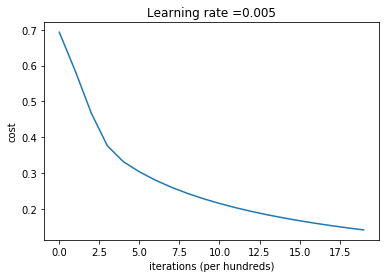

In [18]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 70.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 91.38755980861244 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 71.29186602870814 %
test accuracy: 40.0 %

-------------------------------------------------------



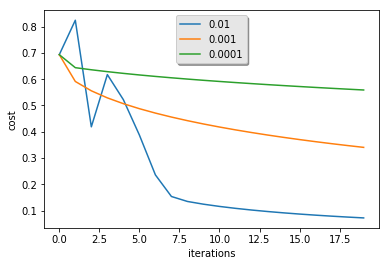

In [19]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

## 6 - Dự đoán ##

y = 1, you predicted that it is a "cat" picture.


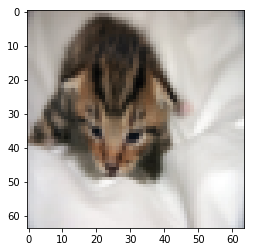

In [20]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")